In [1]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input, EfficientNetB0
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.applications import ResNet50
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_path = "./garbage_classification/"

categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [3]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [4]:
filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + category)
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

df.head()

,filename,category
0,clothes/clothes4033.jpg,clothes
1,biological/biological872.jpg,biological
2,white-glass/white-glass275.jpg,white-glass
3,clothes/clothes2543.jpg,clothes
4,cardboard/cardboard553.jpg,cardboard


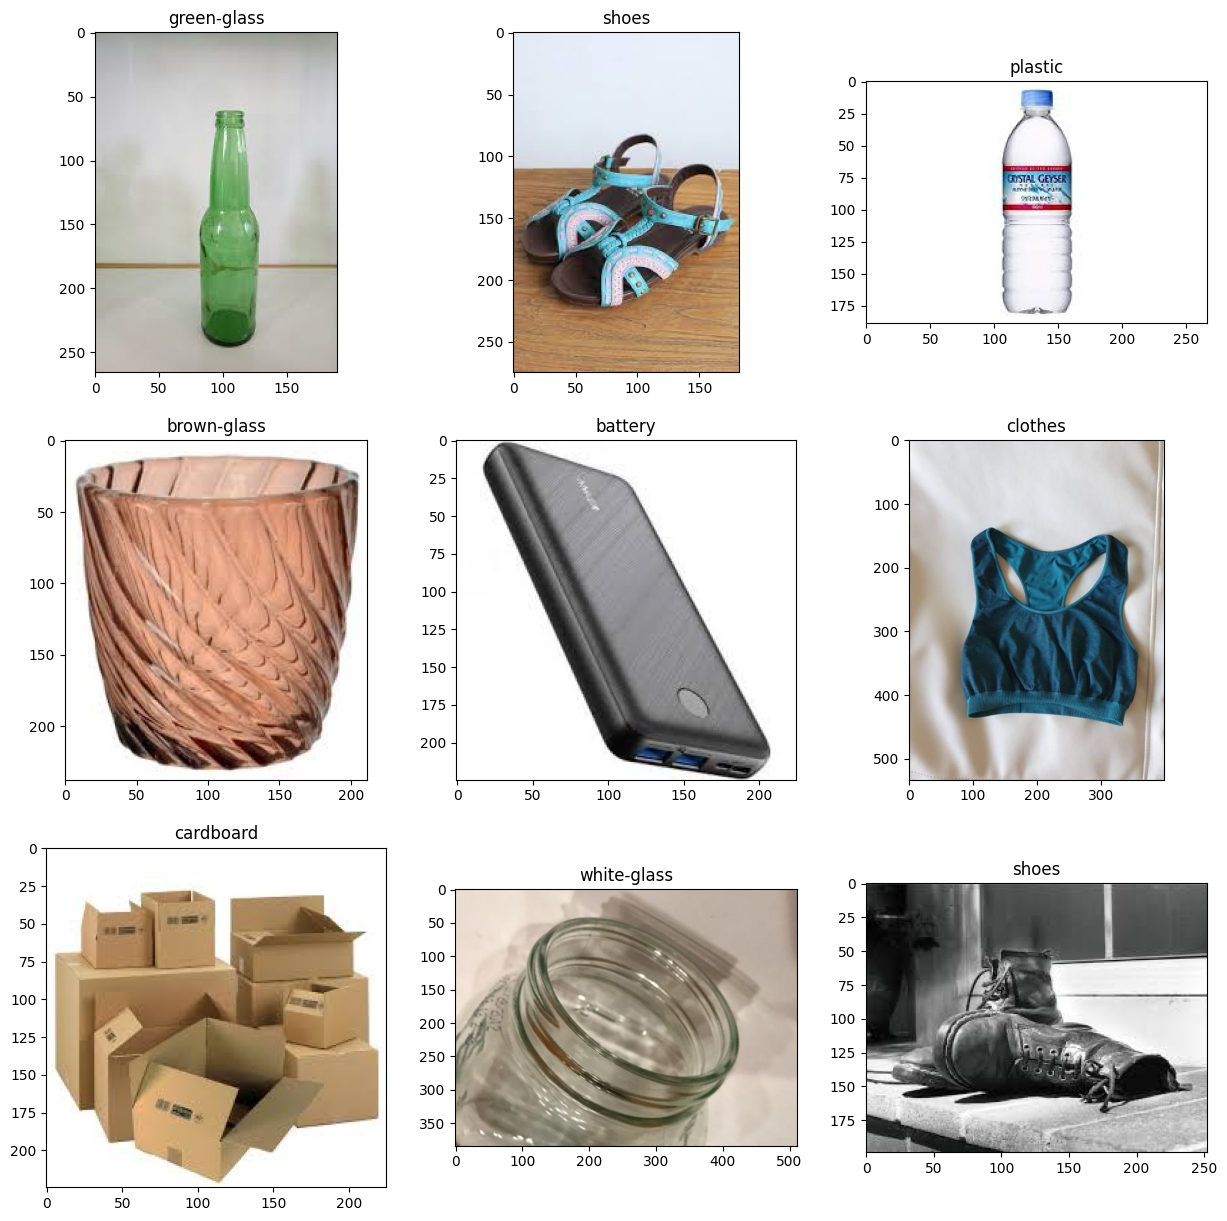

In [5]:

plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = tf.keras.utils.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

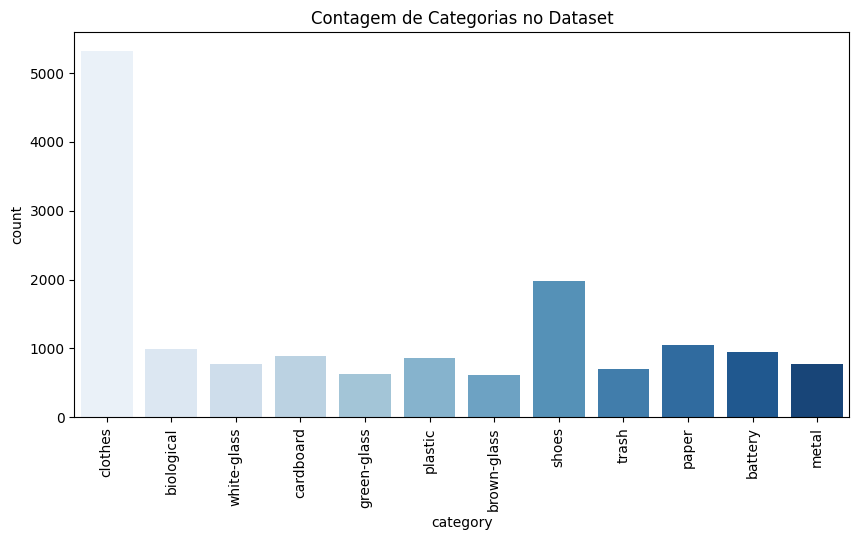

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Contagem de Categorias no Dataset')
plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(12412, 1551, 1552)

In [9]:
train_df.head()

,filename,category
0,battery/battery36.jpg,battery
1,cardboard/cardboard66.jpg,cardboard
2,metal/metal589.jpg,metal
3,plastic/plastic258.jpg,plastic
4,trash/trash576.jpg,trash


In [10]:
im_shape = (224, 224)
batch_size = 64
seed = 42

In [11]:
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 12412 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.
Found 1552 validated image filenames belonging to 12 classes.


In [13]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [14]:
resnet_layer = ResNet50(include_top=False,
                        weights='imagenet',
                        input_shape=(im_shape[0], im_shape[1], 3))

resnet_layer.trainable = False

model = Sequential()
model.add(tf.keras.Input(shape=(im_shape[0], im_shape[1], 3)))

def resnet_preprocessing(img):
    return tf.keras.applications.resnet50.preprocess_input(img)

model.add(Lambda(resnet_preprocessing))

model.add(resnet_layer)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-2),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 23,612,300
Trainable params: 24,588
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
%%time
epochs = 10

#Callback to save the best model
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
193/193 [==============================] - 17s 74ms/step - loss: 1.9822 - accuracy: 0.4093 - val_loss: 1.7542 - val_accuracy: 0.4538
Epoch 2/10
193/193 [==============================] - 14s 70ms/step - loss: 1.7215 - accuracy: 0.4636 - val_loss: 1.6601 - val_accuracy: 0.5059
Epoch 3/10
193/193 [==============================] - 14s 70ms/step - loss: 1.6284 - accuracy: 0.4862 - val_loss: 1.6246 - val_accuracy: 0.5046
Epoch 4/10
193/193 [==============================] - 14s 70ms/step - loss: 1.5512 - accuracy: 0.5112 - val_loss: 1.6122 - val_accuracy: 0.4883
Epoch 5/10
193/193 [==============================] - 14s 70ms/step - loss: 1.5355 - accuracy: 0.5171 - val_loss: 1.5305 - val_accuracy: 0.5293
Epoch 6/10
193/193 [==============================] - 14s 70ms/step - loss: 1.4842 - accuracy: 0.5311 - val_loss: 1.6018 - val_accuracy: 0.4993
Epoch 7/10
193/193 [==============================] - 14s 70ms/step - loss: 1.4770 - accuracy: 0.5398 - val_loss: 1.5548 - val_accuracy:

In [16]:
resnet_layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 23,612,300
Trainable params: 23,559,180
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
%%time
epochs = 50

#Callback to save the best model
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
193/193 [==============================] - 51s 238ms/step - loss: 20.2075 - accuracy: 0.5042 - val_loss: 74.2096 - val_accuracy: 0.0677
Epoch 2/50
193/193 [==============================] - 44s 227ms/step - loss: 2.1140 - accuracy: 0.6922 - val_loss: 27.9219 - val_accuracy: 0.0872
Epoch 3/50
193/193 [==============================] - 44s 226ms/step - loss: 1.2856 - accuracy: 0.7408 - val_loss: 14.8358 - val_accuracy: 0.1589
Epoch 4/50
193/193 [==============================] - 44s 227ms/step - loss: 0.8703 - accuracy: 0.7903 - val_loss: 4.3471 - val_accuracy: 0.3730
Epoch 5/50
193/193 [==============================] - 44s 228ms/step - loss: 0.7205 - accuracy: 0.8287 - val_loss: 1.7409 - val_accuracy: 0.6270
Epoch 6/50
193/193 [==============================] - 44s 227ms/step - loss: 0.6573 - accuracy: 0.8441 - val_loss: 1.6196 - val_accuracy: 0.6940
Epoch 7/50
193/193 [==============================] - 44s 227ms/step - loss: 0.4503 - accuracy: 0.8780 - val_loss: 1.1388 - va

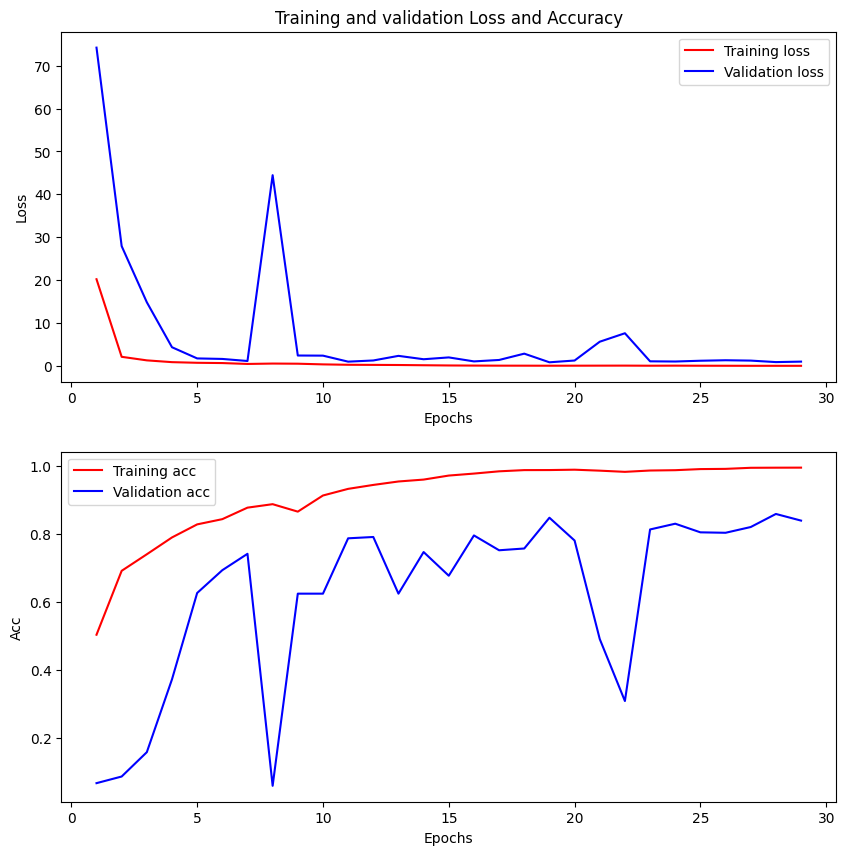

In [18]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'r', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'r', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [19]:
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

25/25 [==============================] - 2s 61ms/step - loss: 0.9873 - accuracy: 0.8401
Val loss: 0.9873009920120239
Val accuracy: 0.8401031494140625


In [20]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1552/1552 [==============================] - 12s 8ms/step - loss: 1.1970 - accuracy: 0.8293
Test loss: 1.1969671249389648
Test accuracy: 0.8292526006698608


1552/1552 [==============================] - 11s 7ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.78      0.74      0.76        97
  biological       0.84      0.87      0.85       107
 brown-glass       0.89      0.81      0.84        67
   cardboard       0.82      0.77      0.79        97
     clothes       0.94      0.97      0.95       525
 green-glass       0.95      0.82      0.88        66
       metal       0.50      0.66      0.57        71
       paper       0.75      0.76      0.75       115
     plastic       0.75      0.58      0.65        85
       shoes       0.90      0.80      0.85       172
       trash       0.70      0.85      0.77        73
 white-glass       0.60      0.62      0.61        77

    accuracy                           0.83      1552
   macro avg       0.78      0.77      0.77      1552
weighted avg       0.84      0.83      0.83      1552



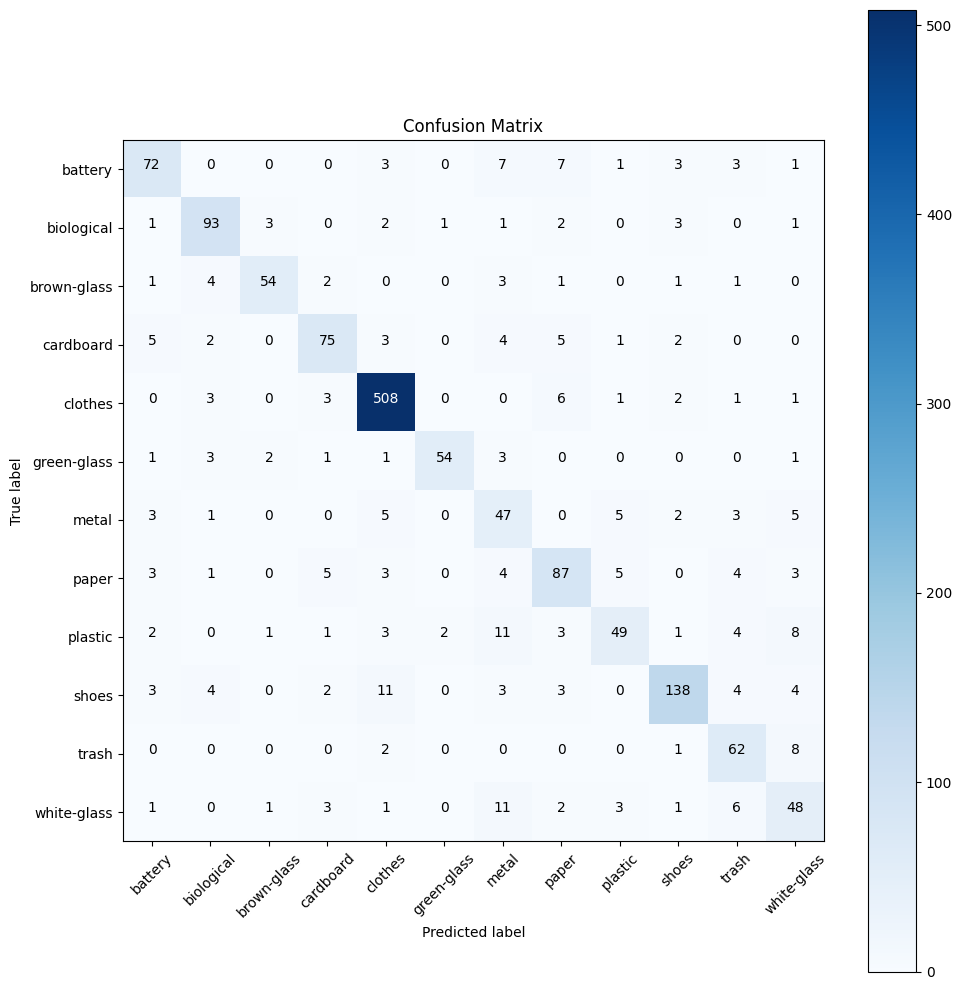

In [21]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))